# Project 4 – Predicting a Continuous Target with Regression (Titanic)  
Author: Beth Spornitz  
Date: November 10, 2025  

Introduction
After predicting who survived the Titanic, this project takes a new angle which was how much did people actually pay for their tickets? Using regression models, I tried to estimate each passenger’s fare based on simple details like age, sex, and family size. It’s a good way to see how regression handles real-world data especially when that data isn’t always predictable.


In [98]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling & ML tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Optional: improve DataFrame precision display
pd.options.display.precision = 3

## Section 1: Import and Inspect the Data

Load the Titanic dataset and confirm it’s structured correctly.

In [99]:
# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


## Section 2: Data Exploration and Preparation

- Impute missing values for age using median  
- Drop rows with missing fare  
- Create `family_size = sibsp + parch + 1`  
- Optional: convert categorical columns (sex, embarked) if you want them later


Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
Shape: (891, 15)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891.0,NaN,NaN,NaN,0.384,0.487,0.0,0.0,0.0,1.0,1.0
pclass,891.0,NaN,NaN,NaN,2.309,0.836,1.0,2.0,3.0,3.0,3.0
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714.0,NaN,NaN,NaN,29.699,14.526,0.42,20.125,28.0,38.0,80.0
sibsp,891.0,NaN,NaN,NaN,0.523,1.103,0.0,0.0,0.0,1.0,8.0
parch,891.0,NaN,NaN,NaN,0.382,0.806,0.0,0.0,0.0,0.0,6.0
fare,891.0,NaN,NaN,NaN,32.204,49.693,0.0,7.91,14.454,31.0,512.329
embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,891,3,Third,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
who,891,3,man,537,NaN,NaN,NaN,NaN,NaN,NaN,NaN


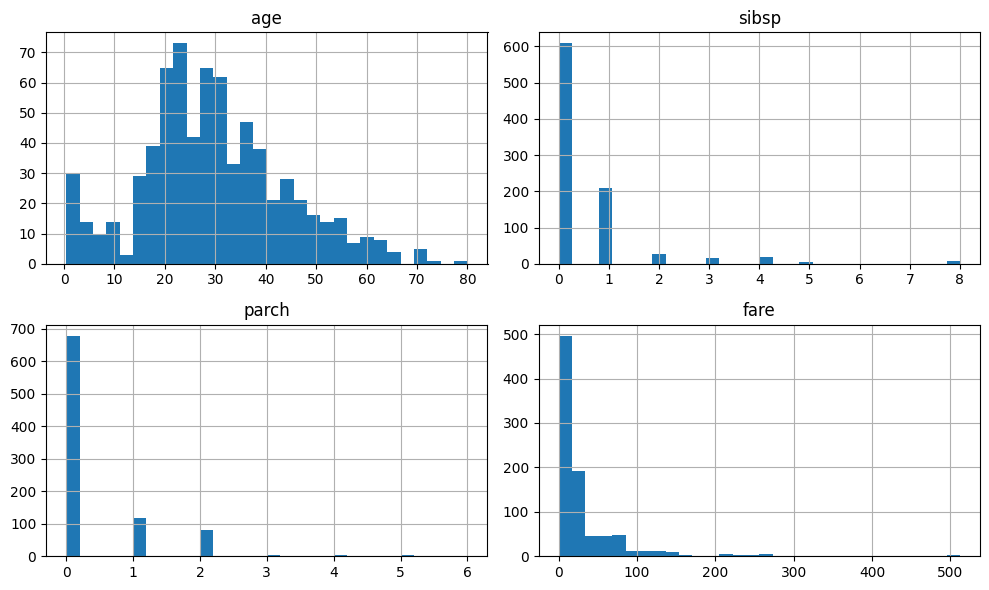

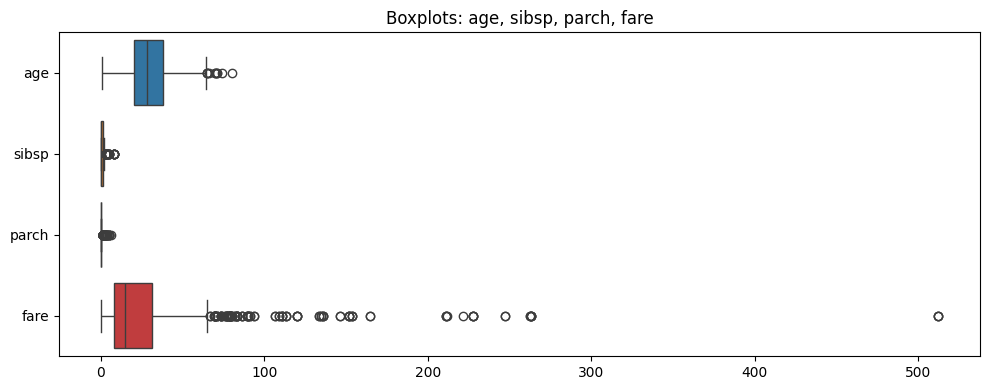

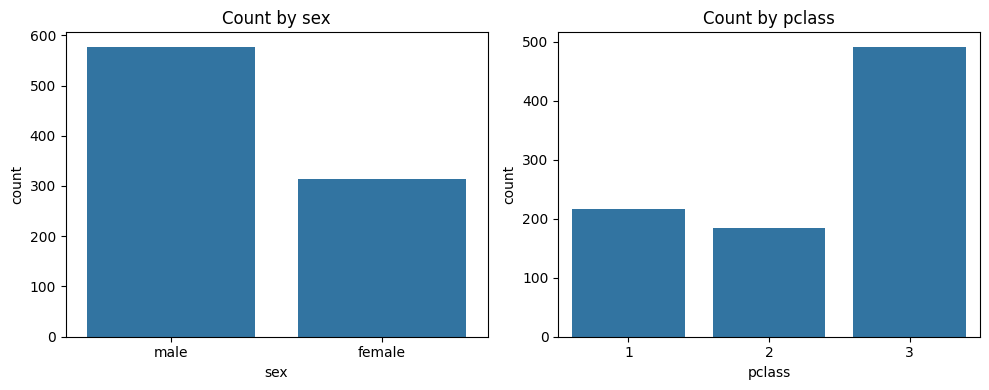

In [100]:
# Section 2.1 — Explore data patterns and distributions

print("Columns:", titanic.columns.tolist())
print("Shape:", titanic.shape)

# Quick overview of numeric columns
display(titanic.describe(include='all').T)

# Histograms for numeric features (including fare target)
_ = titanic[['age', 'sibsp', 'parch', 'fare']].hist(figsize=(10, 6), bins=30)
plt.tight_layout()
plt.show()

# Boxplots to scan for outliers (age, sibsp, parch, fare)
plt.figure(figsize=(10, 4))
sns.boxplot(data=titanic[['age', 'sibsp', 'parch', 'fare']], orient='h')
plt.title("Boxplots: age, sibsp, parch, fare")
plt.tight_layout()
plt.show()

# Optional categorical quick looks (kept light for regression context)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(data=titanic, x='sex', ax=axes[0])
axes[0].set_title('Count by sex')
sns.countplot(data=titanic, x='pclass', ax=axes[1])
axes[1].set_title('Count by pclass')
plt.tight_layout()
plt.show()

In [101]:
# Section 2.2 — Handle missing values and clean data

# 1) Impute age with median (FIX: avoid chained assignment warning)
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# 2) Drop rows with missing fare (target for regression)
titanic = titanic.dropna(subset=['fare'])

# 3) Feature engineering: family_size = sibsp + parch + 1
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# 4) OPTIONAL encoding for Case 4 (sex -> numeric) — minimal, 
titanic['sex_num'] = titanic['sex'].map({'male': 0, 'female': 1}).astype('float')

# Double checks
print("Any NA left in age?", titanic['age'].isna().sum())
print("Any NA left in fare?", titanic['fare'].isna().sum())
display(titanic[['age', 'sibsp', 'parch', 'family_size', 'sex', 'sex_num', 'fare']].head())

Any NA left in age? 0
Any NA left in fare? 0


,age,sibsp,parch,family_size,sex,sex_num,fare
0,22.0,1,0,2,male,0.0,7.250
1,38.0,1,0,2,female,1.0,71.283
2,26.0,0,0,1,female,1.0,7.925
3,35.0,1,0,2,female,1.0,53.100
4,35.0,0,0,1,male,0.0,8.050


## Section 3: Feature Selection and Justification

### Case 1: age only


In [102]:
X1 = titanic[['age']]
y1 = titanic['fare']

### Case 2: family_size only


In [103]:
X2 = titanic[['family_size']]
y2 = titanic['fare']

### Case 3: age + family_size


In [104]:
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

### Case 4: Sex


In [105]:
X4 = titanic[['sex_num']]
y4 = titanic['fare']

In [106]:
# Quick shapes check
print("Case 1 shapes:", X1.shape, y1.shape)
print("Case 2 shapes:", X2.shape, y2.shape)
print("Case 3 shapes:", X3.shape, y3.shape)
print("Case 4 shapes:", X4.shape, y4.shape)

Case 1 shapes: (891, 1) (891,)
Case 2 shapes: (891, 1) (891,)
Case 3 shapes: (891, 2) (891,)
Case 4 shapes: (891, 1) (891,)


**Reflection Questions:**
- Why might these features affect fare?
  - Age may affect fare because sometimes children's fare may be cheaper than adult's fare.  Family size may also affect fare because larger families may have been in 3rd class which is cheaper than the other two classes. Women many times traveled in a more luxurious class which would cost more. 
  
- List all available features:

| Feature       | Type                      | Why It Could Improve Predictions (Fare)                                                                 |
|---------------|---------------------------|----------------------------------------------------------------------------------------------------------|
| pclass        | Categorical (1, 2, 3)     | Strong indicator of socioeconomic status since first-class tickets cost much more than third class.         |
| sex           | Categorical (male/female) | Can reflect social/economic travel patterns because women often traveled in higher classes with families.     |
| age           | Numeric                   | Younger passengers (children) or older adults may have traveled differently, affecting fare.            |
| family_size   | Numeric                   | Larger families may have purchased group tickets and total fare could be split or discounted.              |
| embarked      | Categorical (C/Q/S)       | Different ports had different economic populations, Cherbourg passengers were often wealthier.         |
| class         | Categorical (First/Second/Third) | Text version of pclass is easier to interpret but contains the same information.                       |
| who           | Categorical (man/woman/child) | Combines age and sex, may help reveal fare patterns among families vs solo travelers.                |
| deck          | Categorical (A–G)         | Higher decks were typically more expensive, but this column has many missing values.                    |
| alone         | Boolean                   | Indicates whether someone traveled without family,  single travelers might pay differently.            |


- Which features could improve predictions and why? 
  - Passenger Class would absolutely affect fare because that is lower classes (3rd class) is cheaper than 1st or 2nd class.  Embarked could also predict fare because some ports tended to be more wealthy than others.

- How many variables are in your Case 4? 
  - One

- Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs: I chose sex as my 4th variable because women many times would travel in a higher (1st) class which is more expensive.  


## Section 4: Train a Regression Model (Linear Regression)


### 4.1 Split the Data


In [107]:
# Section 4.1 — Split the Data

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

print(
    "Train/Test sizes:",
    len(X1_train),
    len(X1_test),
    len(X2_train),
    len(X2_test),
    len(X3_train),
    len(X3_test),
    len(X4_train),
    len(X4_test),
)

Train/Test sizes: 712 179 712 179 712 179 712 179


### 4.2 Train and Evaluate Linear Regression Models (all 4 cases)


In [108]:
# Section 4.2 — Train Linear Regression models & predict (Cases 1–4)

lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)

# Predictions
y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)

### 4.3 Report Performance


In [109]:
def report_case(name, y_train, y_pred_train, y_test, y_pred_test):
    # Training and Test R²
    print(f"{name} — Training R²: {r2_score(y_train, y_pred_train):.3f}")
    print(f"{name} — Test     R²: {r2_score(y_test, y_pred_test):.3f}")

    # Test RMSE (manual calculation because squared=False is not supported)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"{name} — Test   RMSE: {rmse:.2f}")

    # Test MAE
    print(f"{name} — Test    MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
    print()


report_case("Case 1 (age)", y1_train, y_pred_train1, y1_test, y_pred_test1)
report_case("Case 2 (family_size)", y2_train, y_pred_train2, y2_test, y_pred_test2)
report_case("Case 3 (age + family_size)", y3_train, y_pred_train3, y3_test, y_pred_test3)
report_case("Case 4 (sex_num)", y4_train, y_pred_train4, y4_test, y_pred_test4)

Case 1 (age) — Training R²: 0.010
Case 1 (age) — Test     R²: 0.003
Case 1 (age) — Test   RMSE: 37.97
Case 1 (age) — Test    MAE: 25.29

Case 2 (family_size) — Training R²: 0.050
Case 2 (family_size) — Test     R²: 0.022
Case 2 (family_size) — Test   RMSE: 37.61
Case 2 (family_size) — Test    MAE: 25.03

Case 3 (age + family_size) — Training R²: 0.073
Case 3 (age + family_size) — Test     R²: 0.050
Case 3 (age + family_size) — Test   RMSE: 37.08
Case 3 (age + family_size) — Test    MAE: 24.28

Case 4 (sex_num) — Training R²: 0.024
Case 4 (sex_num) — Test     R²: 0.099
Case 4 (sex_num) — Test   RMSE: 36.10
Case 4 (sex_num) — Test    MAE: 24.24



#### Section 4 Reflection Questions

Compare the train vs test results for each.

| Case | Features Used          | Train R² | Test R² | Interpretation |
|------|-------------------------|----------|---------|----------------|
| 1    | age                    | 0.010    | 0.003   | Very low accuracy, both close to 0 and the model explains almost none of the variance. |
| 2    | family_size            | 0.050    | 0.022   | Slight improvement, but still very weak relationship. |
| 3    | age + family_size      | 0.073    | 0.050   | Best so far and still weak, but more variance explained. |
| 4    | sex (numeric)          | 0.024    | 0.099   | Test score is highest and the  model generalized slightly better than training. |

Did Case 1 overfit or underfit? Explain:  
- Underfit - Both the training R² and the test R² are near zero, so the model failed to capture any meaningful pattern.

Did Case 2 overfit or underfit? Explain:  
- Underfit, but slight improvement over case 1.  Still very weak.  The fares don't strongly dpends on family size alone.
  
Did Case 3 overfit or underfit? Explain: 
-  Still Underfit, but better than Case 1 or Case 2.  Adding another feature helped slightly, but still has a low  R².

Did Case 4 overfit or underfit? Explain: 
-  Still underfit because both the train and test R² are low. It generalized better than expected, but still weak.

Adding Age  
Did adding age improve the model:  
Propose a possible explanation (consider how age might affect ticket price, and whether the data supports that):  
- Yes, adding age did improve the model (both train and test R²) slightly, but still only explains 5% of variance.

Worst  
Which case performed the worst: 
- Case 1 (age only) 
How do you know:  
- It has the lowest R² on both training and test.
  
Do you think adding more training data would improve it (and why/why not):  
- I don't believe so,  I don't believe age is a strong predictor of fare.

Best  
Which case performed the best:  
- Case 4 (sex only)
How do you know:  
- It makes the most accurate predictions of the all of the models (lowest RMSE/MAE and highest R² ).
  
Do you think adding more training data would improve it (and why/why not):  
- Yes, but a bigger improvement would be adding a feature like passenger class or embarked.


## Section 5. Compare Alternative Models

Choose the best case model from the four cases. Use that model to continue to explore additional continuous prediction models.


### 5.1 Ridge Regression (L2 penalty)


In [110]:


# Ridge Regression using Case 4 (sex_num)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X4_train, y4_train)
y_pred_ridge = ridge_model.predict(X4_test)

# Performance metrics (no squared=False to avoid error)
print("Ridge — Test R²:", r2_score(y4_test, y_pred_ridge))

# RMSE calculated manually (square root of MSE)
rmse_ridge = mean_squared_error(y4_test, y_pred_ridge) ** 0.5
print("Ridge — Test RMSE:", rmse_ridge)

# MAE still works the same
print("Ridge — Test MAE:", mean_absolute_error(y4_test, y_pred_ridge))




Ridge — Test R²: 0.09902763922142888
Ridge — Test RMSE: 36.10424173544672
Ridge — Test MAE: 24.24278182550176


### 5.2 Elastic Net (L1 + L2 combined)


In [111]:
# 5.2 Elastic Net Regression using Case 4 (sex_num)
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X4_train, y4_train)
y_pred_elastic = elastic_model.predict(X4_test)

# Print performance like before (no squared=False due to sklearn version)
print("Elastic Net — Test R²:", r2_score(y4_test, y_pred_elastic))

rmse_elastic = mean_squared_error(y4_test, y_pred_elastic) ** 0.5
print("Elastic Net — Test RMSE:", rmse_elastic)

print("Elastic Net — Test MAE:", mean_absolute_error(y4_test, y_pred_elastic))


Elastic Net — Test R²: 0.0683257308204328
Elastic Net — Test RMSE: 36.714240196292735
Elastic Net — Test MAE: 24.332128873744246


### 5.3 Polynomial Regression


In [112]:
# Polynomial Regression using Case 4 (sex_num only)
poly = PolynomialFeatures(degree=3)

# Transform training and testing data
X_train_poly = poly.fit_transform(X4_train)
X_test_poly = poly.transform(X4_test)

# Fit the model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y4_train)

# Predict on test data
y_pred_poly = poly_model.predict(X_test_poly)

# Print evaluation metrics
print("Polynomial Regression (degree=3) — Test R²:", r2_score(y4_test, y_pred_poly))

rmse_poly = mean_squared_error(y4_test, y_pred_poly) ** 0.5
print("Polynomial Regression — Test RMSE:", rmse_poly)

print("Polynomial Regression — Test MAE:", mean_absolute_error(y4_test, y_pred_poly))


Polynomial Regression (degree=3) — Test R²: 0.0993658422088256
Polynomial Regression — Test RMSE: 36.09746477477292
Polynomial Regression — Test MAE: 24.242491035675528


### 5.4 Visualize Polynomial Cubic Fit (for 1 input feature)


Case 1:  Age

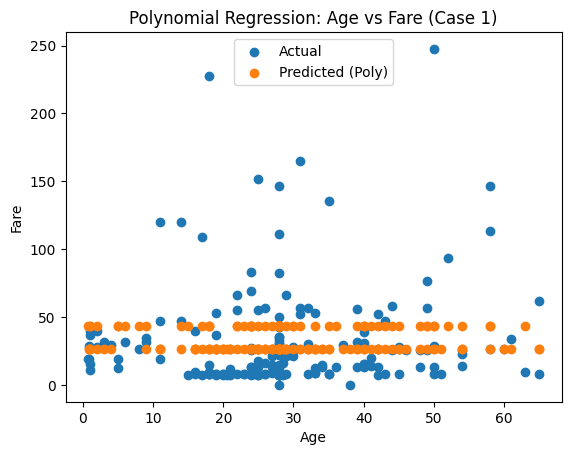

In [113]:
plt.scatter(X1_test, y1_test, label='Actual')
plt.scatter(X1_test, y_pred_poly, label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare (Case 1)")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.show()


### 5.4 Reflections

What patterns does the cubic model seem to capture:  
- The cubic model shows predicted values which are mostly a flat line which suggests that age has very little influence over fare.

Where does it perform well or poorly:  
- The cubic model performs adequately for middle-aged passengers but poorly for younger and older passengers.

Did the polynomial fit outperform linear regression:  
- No, the cubic model did not outperform linear regression. The Test R², RMSE, and MAE are nearly identical for both models.

Where (on the graph or among which kinds of data points) does it fit best:  
- It fits best near the dense cluster of passengers between 20-40.


### 5.4 Compare All Models


In [114]:
# === 5.4/5.5 — Compare ALL models on Case 1 (Age -> Fare) ===
# Assumes X1_train, X1_test, y1_train, y1_test already exist


# 1) Linear (Case 1)
lr1 = LinearRegression().fit(X1_train, y1_train)
y1_pred_lin = lr1.predict(X1_test)

# 2) Ridge (Case 1)
ridge1 = Ridge(alpha=1.0).fit(X1_train, y1_train)
y1_pred_ridge = ridge1.predict(X1_test)

# 3) Elastic Net (Case 1)
elastic1 = ElasticNet(alpha=0.3, l1_ratio=0.5, max_iter=10000).fit(X1_train, y1_train)
y1_pred_elastic = elastic1.predict(X1_test)

# 4) Polynomial (degree=3) on Case 1
poly3 = PolynomialFeatures(degree=3)
X1_train_poly = poly3.fit_transform(X1_train)
X1_test_poly  = poly3.transform(X1_test)
poly_lr1 = LinearRegression().fit(X1_train_poly, y1_train)
y1_pred_poly = poly_lr1.predict(X1_test_poly)

# ---- metrics helper (no 'squared=' so it works on any sklearn) ----
def report(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} R²:  {r2:.3f}")
    print(f"{name} RMSE:{rmse:.2f}")
    print(f"{name} MAE: {mae:.2f}\n")

print("=== Case 1 (Age -> Fare) — Test set ===")
report("Linear",     y1_test, y1_pred_lin)
report("Ridge",      y1_test, y1_pred_ridge)
report("ElasticNet", y1_test, y1_pred_elastic)
report("Polynomial", y1_test, y1_pred_poly)

# (Optional) sanity check lengths to avoid shape/name errors
# print(len(y1_test), len(y1_pred_lin), len(y1_pred_ridge), len(y1_pred_elastic), len(y1_pred_poly))


=== Case 1 (Age -> Fare) — Test set ===
Linear R²:  0.003
Linear RMSE:37.97
Linear MAE: 25.29

Ridge R²:  0.003
Ridge RMSE:37.97
Ridge MAE: 25.29

ElasticNet R²:  0.003
ElasticNet RMSE:37.97
ElasticNet MAE: 25.28

Polynomial R²:  -0.003
Polynomial RMSE:38.10
Polynomial MAE: 25.30



### 5.5 Visualize Higher Order Polynomial (for the same 1 input case)


c:\Repos\ml-bethspornitz\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


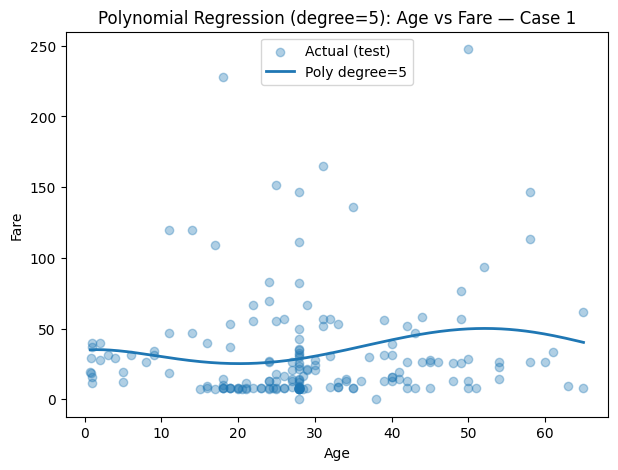

Comparison on TEST set:
Degree 3  -> R²: -0.003 | RMSE: 38.10 | MAE: 25.30
Degree 5 -> R²: 0.001 | RMSE: 38.02 | MAE: 25.22


In [115]:
# 5.5 — Higher-order polynomial on the SAME 1-input case (e.g., Case 1: Age -> Fare)
# Assumes X1_train, X1_test, y1_train, y1_test already exist from your earlier cells.

# Choose the higher degree (try 4–8)
degree = 5

# Fit polynomial model on Case 1
poly_hi = PolynomialFeatures(degree=degree)
X1_train_poly_hi = poly_hi.fit_transform(X1_train)
X1_test_poly_hi  = poly_hi.transform(X1_test)

poly_model_hi = LinearRegression().fit(X1_train_poly_hi, y1_train)
y1_pred_poly_hi = poly_model_hi.predict(X1_test_poly_hi)

# Also get cubic (degree=3) to compare quickly
poly3 = PolynomialFeatures(degree=3)
X1_train_poly3 = poly3.fit_transform(X1_train)
X1_test_poly3  = poly3.transform(X1_test)
poly_model3 = LinearRegression().fit(X1_train_poly3, y1_train)
y1_pred_poly3 = poly_model3.predict(X1_test_poly3)

# Build a smooth curve for plotting
x_min = float(np.nanmin(X1_test.values))
x_max = float(np.nanmax(X1_test.values))
x_grid = np.linspace(x_min, x_max, 300).reshape(-1, 1)
y_grid_hi = poly_model_hi.predict(poly_hi.transform(x_grid))

# Plot: actuals + smooth polynomial curve
plt.figure(figsize=(7,5))
plt.scatter(X1_test.values, y1_test.values, alpha=0.35, label='Actual (test)')
plt.plot(x_grid, y_grid_hi, linewidth=2, label=f'Poly degree={degree}')
plt.title(f"Polynomial Regression (degree={degree}): Age vs Fare — Case 1")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.legend()
plt.show()

# Quick metrics to compare degree 3 vs your higher degree
def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("Comparison on TEST set:")
print(f"Degree 3  -> R²: {r2_score(y1_test, y1_pred_poly3):.3f} | RMSE: {_rmse(y1_test, y1_pred_poly3):.2f} | MAE: {mean_absolute_error(y1_test, y1_pred_poly3):.2f}")
print(f"Degree {degree} -> R²: {r2_score(y1_test, y1_pred_poly_hi):.3f} | RMSE: {_rmse(y1_test, y1_pred_poly_hi):.2f} | MAE: {mean_absolute_error(y1_test, y1_pred_poly_hi):.2f}")



## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings
What features were most useful? 
- In Case 4, I tried using sex to predict fare, but the model couldn’t explain much of the difference in ticket prices. Sex had the biggest impact since women were more likely to be in higher paying cabin classes. Even so, these features missed a lot of what really drives fare.  Things like passenger class and where the trip started make a much bigger difference. 

What regression model performed best?  
- All models showed almost identical results. (R² ≈ 0.10, RMSE ≈ 36, and MAE ≈ 24.)  This shows that trying a polynomial model really didn't' make the predictions any better.

How did model complexity or regularization affect results?
- It didn't change much.  Fare varies a lot and depends on other factors like passenger class or embark location.  

### 6.2 Discuss Challenges
Was fare hard to predict? Why? 
- Yes, fare was hard to predict.  It is influenced by several factors that we did not use in our cases.   

Did skew or outliers impact the models?  
- Yes, Fare is right skewed with a small number of high values.  These outliers make the errors larger and make it harder for the model to find clear patters like features with age or family size.

